In [1]:
import pandas as pd
import sqlite3
import numpy as np

connection = sqlite3.connect('german_credit.db')
cursor = connection.cursor()

def select(query):
    try:
        return pd.read_sql_query(query, connection)
    except:
        cursor.executescript(query)
        connection.commit()

query = r'''
    SELECT * 
    FROM german_credit
'''
df = select(query).assign(contract_dt = lambda x: x['contract_dt'].astype('datetime64[ns]'))

In [3]:
df = pd.read_csv('../german_credit_augmented.csv')

In [6]:
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,NaN,NaN,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,NaN,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,NaN,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,NaN,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   job               1000 non-null   int64 
 3   housing           1000 non-null   object
 4   saving_accounts   817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   default           1000 non-null   int64 
 10  contract_dt       1000 non-null   object
 11  client_id         1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


In [8]:
df.to_sql('german_credit', connection, index=False, if_exists='replace')

1000

In [9]:
query = r'''
    SELECT *
    FROM german_credit
    LIMIT 5
'''
select(query)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,None,None,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,None,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,None,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,None,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [42]:
query = r'''
    SELECT 
        DISTINCT housing
    FROM german_credit
'''
list_housing = list(select(query)['housing'])
s = []
for x in list_housing:
    s = s + [f'COUNT(CASE WHEN housing = "{x}" THEN 1 END) AS {x}']
s = ',\n'.join(s)

In [43]:
query = rf'''
    SELECT 
        sex,
        {s}
    FROM german_credit
    GROUP BY sex
'''
select(query)

,sex,own,rent,free
0,female,196,95,19
1,male,517,84,89


In [5]:
pd.pivot_table(data = df, index = ['sex'], columns= 'housing', aggfunc = {'client_id': 'count'})

client_id          
housing      free  own rent
sex                        
female         19  196   95
male           89  517   84

In [15]:
# How can we return rows from the first two (not empty) days for each month?
query = r'''
    WITH date_part AS (
    SELECT *, 
        date(contract_dt, 'start of day') AS day,  
        date(contract_dt, 'start of month') AS month,
        DENSE_RANK() OVER w AS rank_date
    FROM german_credit
    WINDOW w AS (PARTITION BY date(contract_dt, 'start of month') ORDER BY date(contract_dt, 'start of day'))
    ORDER BY contract_dt
    )
    SELECT *
    FROM date_part 
    WHERE rank_date IN (1, 2)
    LIMIT 20
'''
select(query)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id,day,month,rank_date
0,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495,2007-05-01,2007-05-01,1
1,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288,2007-05-01,2007-05-01,1
2,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141,2007-05-01,2007-05-01,1
3,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215,2007-05-01,2007-05-01,1
4,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598,2007-05-01,2007-05-01,1
5,36,male,2,own,little,moderate,884,18,car,1,2007-05-02 06:22:11,184,2007-05-02,2007-05-01,2
6,52,male,2,own,moderate,None,2223,24,radio/TV,0,2007-06-01 04:40:51,773,2007-06-01,2007-06-01,1
7,29,female,1,rent,little,little,1659,24,radio/TV,1,2007-06-01 06:50:39,466,2007-06-01,2007-06-01,1
8,64,male,1,own,None,None,3832,9,education,0,2007-06-01 11:55:15,629,2007-06-01,2007-06-01,1
9,37,male,2,free,None,None,2279,12,radio/TV,0,2007-06-01 12:33:25,681,2007-06-01,2007-06-01,1


In [35]:
query = r'''
    SELECT * 
    FROM german_credit
'''
df = select(query).assign(contract_dt = lambda x: x['contract_dt'].astype('datetime64[ns]'))

In [18]:
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
0,33,male,2,own,None,None,3074,9,radio/TV,0,2008-06-29 18:52:00,210
1,43,male,1,own,little,little,1344,12,car,0,2007-05-20 18:30:19,929
2,52,male,2,own,quite rich,None,936,9,education,0,2008-04-27 08:23:07,200
3,35,female,3,own,little,None,1393,11,car,0,2007-05-06 10:58:22,45
4,28,male,2,own,little,None,776,12,radio/TV,0,2007-07-21 13:22:14,358


In [33]:
# first two days of month (as date)
(
    df
    .assign(rank = lambda x: x['contract_dt'].astype('datetime64[ns]').dt.day)
    .query('rank in [1, 2]')
    .sort_values('contract_dt')
    .head(20)
)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id,rank
590,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495,1
725,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288,1
282,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141,1
578,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215,1
587,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598,1
441,36,male,2,own,little,moderate,884,18,car,1,2007-05-02 06:22:11,184,2
184,52,male,2,own,moderate,None,2223,24,radio/TV,0,2007-06-01 04:40:51,773,1
583,29,female,1,rent,little,little,1659,24,radio/TV,1,2007-06-01 06:50:39,466,1
563,64,male,1,own,None,None,3832,9,education,0,2007-06-01 11:55:15,629,1
46,37,male,2,free,None,None,2279,12,radio/TV,0,2007-06-01 12:33:25,681,1


In [72]:
# first two not empty days of each month
(
    df
    .sort_values('contract_dt')
    .assign(rank = lambda x: x.groupby(x['contract_dt'].dt.to_period('M'))['contract_dt'].transform(lambda x: x.dt.date.rank(method = 'dense')))
    .query('rank in [1, 2]')
    .head(20)
)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id,rank
590,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495,1.0
725,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288,1.0
282,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141,1.0
578,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215,1.0
587,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598,1.0
441,36,male,2,own,little,moderate,884,18,car,1,2007-05-02 06:22:11,184,2.0
184,52,male,2,own,moderate,None,2223,24,radio/TV,0,2007-06-01 04:40:51,773,1.0
583,29,female,1,rent,little,little,1659,24,radio/TV,1,2007-06-01 06:50:39,466,1.0
563,64,male,1,own,None,None,3832,9,education,0,2007-06-01 11:55:15,629,1.0
46,37,male,2,free,None,None,2279,12,radio/TV,0,2007-06-01 12:33:25,681,1.0


In [74]:
(
    df
    .sort_values('contract_dt')
    .assign(double_value = lambda x: x.groupby(df['contract_dt'].dt.to_period('M'))['credit_amount'].transform(lambda x: np.sum(x)))
    .head(200)
)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id,double_value
590,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495,207663
725,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288,207663
282,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141,207663
578,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215,207663
587,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598,207663
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,36,male,2,rent,little,little,2799,9,car,0,2007-07-18 19:32:17,586,224333
752,34,female,3,own,little,moderate,1501,9,education,1,2007-07-18 22:04:00,195,224333
158,34,male,1,own,None,None,1898,6,radio/TV,0,2007-07-19 00:24:14,159,224333
731,60,male,2,free,little,None,2032,24,car,0,2007-07-19 02:59:31,541,224333


In [73]:
(
    df
    .sort_values('contract_dt')
    .groupby(df['contract_dt'].dt.to_period('M'))
    ['credit_amount'].sum()
)

contract_dt
2007-05    207663
2007-06    239594
2007-07    224333
2007-08    178569
2007-09    186909
2007-10    188534
2007-11    300504
2007-12    273973
2008-01    288080
2008-02    211128
2008-03    204944
2008-04    305409
2008-05    263043
2008-06    198575
Freq: M, Name: credit_amount, dtype: int64

In [3]:
# percent of total credit_amount of each month
(
    df
    .sort_values('contract_dt')
    .assign(month_total = lambda x: x.groupby(x['contract_dt'].dt.to_period('M'))['credit_amount'].transform(lambda x: x.sum()))
    .assign(**{'perc_of_month, %': lambda x: x['credit_amount'] * 100 / x['month_total']})
    .assign(month = lambda x: x['contract_dt'].dt.to_period('M'))
    [['client_id', 'contract_dt', 'month', 'credit_amount', 'month_total', 'perc_of_month, %']]
    
)

,client_id,contract_dt,month,credit_amount,month_total,"perc_of_month, %"
590,495,2007-05-01 07:17:29,2007-05,2996,207663,1.442722
725,288,2007-05-01 08:41:46,2007-05,1092,207663,0.525852
282,141,2007-05-01 12:42:45,2007-05,4795,207663,2.309030
578,215,2007-05-01 20:28:44,2007-05,932,207663,0.448804
587,598,2007-05-01 23:14:02,2007-05,2775,207663,1.336300
...,...,...,...,...,...,...
286,928,2008-06-28 11:49:14,2008-06,1867,198575,0.940199
233,196,2008-06-28 12:33:38,2008-06,1382,198575,0.695959
111,520,2008-06-28 14:08:06,2008-06,5507,198575,2.773259
334,105,2008-06-28 23:47:51,2008-06,11938,198575,6.011834


In [2]:
# percent of total credit_amount of each month (SQL)
query = r'''
    SELECT 
        client_id,
        contract_dt,
        date(contract_dt, 'start of month') AS month,
        credit_amount,
        SUM(credit_amount) OVER w AS month_total,
        credit_amount * 100.0 / SUM(credit_amount) OVER w AS perc_of_month
    FROM german_credit
    WINDOW w AS (PARTITION BY date(contract_dt, 'start of month'))
    ORDER BY contract_dt
'''
select(query)

,client_id,contract_dt,month,credit_amount,month_total,perc_of_month
0,495,2007-05-01 07:17:29,2007-05-01,2996,207663,1.442722
1,288,2007-05-01 08:41:46,2007-05-01,1092,207663,0.525852
2,141,2007-05-01 12:42:45,2007-05-01,4795,207663,2.309030
3,215,2007-05-01 20:28:44,2007-05-01,932,207663,0.448804
4,598,2007-05-01 23:14:02,2007-05-01,2775,207663,1.336300
...,...,...,...,...,...,...
995,928,2008-06-28 11:49:14,2008-06-01,1867,198575,0.940199
996,196,2008-06-28 12:33:38,2008-06-01,1382,198575,0.695959
997,520,2008-06-28 14:08:06,2008-06-01,5507,198575,2.773259
998,105,2008-06-28 23:47:51,2008-06-01,11938,198575,6.011834


In [44]:
# rollmean (current row and 2 preceding) in 2007-06) SQLITE
query = r'''
    SELECT 
        contract_dt,
        strftime('%Y-%m', contract_dt) AS month,
        credit_amount,
        ROUND(AVG(credit_amount) OVER w, 2) AS rollmean
    FROM german_credit
    WHERE date(contract_dt, 'start of month') = '2007-06-01'
    WINDOW w AS (
        PARTITION BY date(contract_dt, 'start of month')
        ORDER BY contract_dt
        ROWS BETWEEN 2 preceding AND current row
     )
     ORDER BY contract_dt
     
'''
select(query)

,contract_dt,month,credit_amount,rollmean
0,2007-06-01 04:40:51,2007-06,2223,2223.00
1,2007-06-01 06:50:39,2007-06,1659,1941.00
2,2007-06-01 11:55:15,2007-06,3832,2571.33
3,2007-06-01 12:33:25,2007-06,2279,2590.00
4,2007-06-01 13:18:05,2007-06,13756,6622.33
...,...,...,...,...
69,2007-06-30 13:04:06,2007-06,2101,1975.00
70,2007-06-30 16:22:32,2007-06,3378,2585.67
71,2007-06-30 20:03:08,2007-06,3972,3150.33
72,2007-06-30 23:13:06,2007-06,6314,4554.67


In [106]:
# rollmean (current row and 2 preceding) in 2007-06) PANDAS
df_june = (
    df
    .sort_values('contract_dt')
    .assign(month = lambda x: x['contract_dt'].dt.to_period('M'),
           rollmean = lambda x: x.groupby(x['contract_dt'].dt.to_period('M'))['credit_amount']
            .transform(lambda x: x.rolling(3, min_periods = 1).mean().round(2))
           )
    .query('month.astype("str") == "2007-06"')
)[['contract_dt', 'month', 'credit_amount', 'rollmean']]
df_june.head(20)

,contract_dt,month,credit_amount,rollmean
184,2007-06-01 04:40:51,2007-06,2223,2223.00
583,2007-06-01 06:50:39,2007-06,1659,1941.00
563,2007-06-01 11:55:15,2007-06,3832,2571.33
46,2007-06-01 12:33:25,2007-06,2279,2590.00
454,2007-06-01 13:18:05,2007-06,13756,6622.33
65,2007-06-02 00:46:37,2007-06,3161,6398.67
181,2007-06-02 03:46:50,2007-06,2121,6346.00
726,2007-06-02 06:58:10,2007-06,2124,2468.67
281,2007-06-03 11:35:18,2007-06,1935,2060.00
261,2007-06-03 17:20:48,2007-06,1442,1833.67


In [125]:
# Top 10 credit amount pandas 
(
    df
    .assign(credit_rank = lambda x: x['credit_amount'].rank(method = 'dense', ascending = False))
    .query(f'credit_rank < 11')
    .sort_values('credit_rank')
    [['credit_rank', 'credit_amount', 'contract_dt']]
    .set_index('credit_rank')
)

,credit_amount,contract_dt
credit_rank,,
1.0,18424,2007-12-21 01:36:29
2.0,15945,2007-08-04 20:10:36
3.0,15857,2007-05-16 07:20:08
4.0,15672,2007-11-30 06:46:27
5.0,15653,2008-04-26 15:28:20
6.0,14896,2008-05-09 12:43:29
7.0,14782,2007-06-11 07:08:00
8.0,14555,2008-03-30 12:45:07
9.0,14421,2008-01-11 22:06:07


In [124]:
# top 10 credit amount in SQL
query = fr'''
    WITH get_rank AS (
    SELECT 
        DENSE_RANK() OVER w AS credit_rank,
        credit_amount,
        contract_dt
    FROM german_credit
    WINDOW w AS (
        ORDER BY credit_amount DESC
    ))
    SELECT 
        credit_rank,
        credit_amount,
        contract_dt
    FROM get_rank
    WHERE credit_rank < 11
'''
select(query)

,credit_rank,credit_amount,contract_dt
0,1,18424,2007-12-21 01:36:29
1,2,15945,2007-08-04 20:10:36
2,3,15857,2007-05-16 07:20:08
3,4,15672,2007-11-30 06:46:27
4,5,15653,2008-04-26 15:28:20
5,6,14896,2008-05-09 12:43:29
6,7,14782,2007-06-11 07:08:00
7,8,14555,2008-03-30 12:45:07
8,9,14421,2008-01-11 22:06:07
9,10,14318,2007-12-16 18:47:38


In [127]:
(
    df
    .sort_values('contract_dt')
    .head(20)
)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,default,contract_dt,client_id
590,20,male,2,own,None,little,2996,24,furniture/equipment,1,2007-05-01 07:17:29,495
725,49,female,2,own,little,moderate,1092,12,radio/TV,0,2007-05-01 08:41:46,288
282,30,female,3,own,little,moderate,4795,36,radio/TV,0,2007-05-01 12:42:45,141
578,39,female,1,own,None,moderate,932,6,education,0,2007-05-01 20:28:44,215
587,31,male,2,own,little,None,2775,18,car,1,2007-05-01 23:14:02,598
441,36,male,2,own,little,moderate,884,18,car,1,2007-05-02 06:22:11,184
936,27,female,1,own,little,little,3643,15,furniture/equipment,0,2007-05-03 04:28:36,319
719,47,male,3,own,little,moderate,1209,6,car,1,2007-05-03 10:29:01,485
551,55,female,0,free,little,little,1190,18,repairs,1,2007-05-05 00:14:17,429
775,30,male,3,own,quite rich,None,2333,30,radio/TV,0,2007-05-05 01:25:39,40


In [261]:
get_min_diff = r'''
    SELECT 
            MIN(credit_amount) AS min_amount,
            (MAX(credit_amount) - MIN(credit_amount)) * 1.0 / 20 AS diff_amount
        FROM german_credit
'''
min_credit, diff_credit = select(get_min_diff).iloc[0,:].to_list()
s = []
for i in range(19):
    s.append(f'WHEN credit_amount > {min_credit + diff_credit * (i) - 1} AND credit_amount <= {min_credit + diff_credit * (i+1)} THEN {i+1}')
s = ' '.join(s)
s
query = fr'''
    WITH get_groups AS (
    SELECT 
        contract_dt,
        credit_amount,
        CASE {s} ELSE 20 END AS groups_amount
    FROM german_credit
    )
    SELECT 
        groups_amount,
        SUM(credit_amount) AS sum_credit, 
        COUNT(credit_amount) AS count_groups
    FROM get_groups
    GROUP BY groups_amount
'''
select(query).set_index('groups_amount')

,sum_credit,count_groups
groups_amount,,
1,122044,151
2,451697,294
3,421207,170
4,419563,123
5,283319,66
6,159649,31
7,276961,45
8,248478,35
9,190580,24


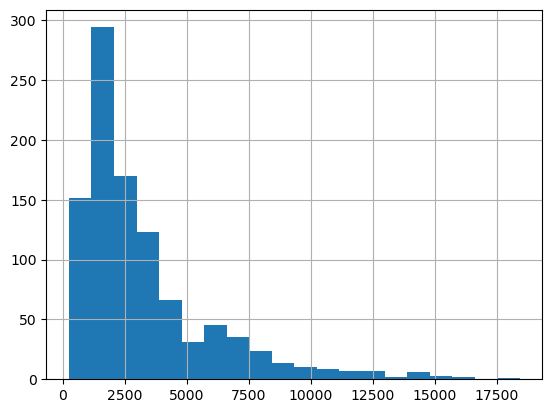

In [227]:
df['credit_amount'].hist(bins=20);

In [230]:
count, division = np.histogram(df['credit_amount'], bins=20)

In [237]:
np.histogram(df['credit_amount'], bins=20)

(array([151, 294, 170, 123,  66,  31,  45,  35,  24,  14,  10,   9,   7,
          7,   2,   6,   3,   2,   0,   1]),
 array([  250. ,  1158.7,  2067.4,  2976.1,  3884.8,  4793.5,  5702.2,
         6610.9,  7519.6,  8428.3,  9337. , 10245.7, 11154.4, 12063.1,
        12971.8, 13880.5, 14789.2, 15697.9, 16606.6, 17515.3, 18424. ]))

In [232]:
division

array([  250. ,  1158.7,  2067.4,  2976.1,  3884.8,  4793.5,  5702.2,
        6610.9,  7519.6,  8428.3,  9337. , 10245.7, 11154.4, 12063.1,
       12971.8, 13880.5, 14789.2, 15697.9, 16606.6, 17515.3, 18424. ])

In [236]:
pd.DataFrame({'count': count}, index = np.arange(1,21) )

,count
1,151
2,294
3,170
4,123
5,66
6,31
7,45
8,35
9,24
10,14


In [259]:
pd.cut(df['credit_amount'], bins = 20, include_lowest=True)

0       (2976.1, 3884.8]
1       (1158.7, 2067.4]
2      (231.825, 1158.7]
3       (1158.7, 2067.4]
4      (231.825, 1158.7]
             ...        
995     (2067.4, 2976.1]
996     (3884.8, 4793.5]
997     (5702.2, 6610.9]
998     (4793.5, 5702.2]
999     (1158.7, 2067.4]
Name: credit_amount, Length: 1000, dtype: category
Categories (20, interval[float64, right]): [(231.825, 1158.7] < (1158.7, 2067.4] < (2067.4, 2976.1] < (2976.1, 3884.8] ... (14789.2, 15697.9] < (15697.9, 16606.6] < (16606.6, 17515.3] < (17515.3, 18424.0]]

In [14]:
# Sum and count of df divided by 20 groups by value of credit_amount
(
    df
    .sort_values('credit_amount')
    .assign(groups_20 = lambda x: pd.cut(x['credit_amount'], bins = 20, include_lowest=True, right = True))
    .groupby('groups_20', observed=False)['credit_amount'].agg(['sum', 'count'])
    .sort_values('count', ascending = False)
    .reset_index(drop=False)
    .set_index(np.arange(1, 21))
)

,groups_20,sum,count
1,"(1158.7, 2067.4]",451697,294
2,"(2067.4, 2976.1]",421207,170
3,"(231.825, 1158.7]",122044,151
4,"(2976.1, 3884.8]",419563,123
5,"(3884.8, 4793.5]",283319,66
6,"(5702.2, 6610.9]",276961,45
7,"(6610.9, 7519.6]",248478,35
8,"(4793.5, 5702.2]",159649,31
9,"(7519.6, 8428.3]",190580,24
10,"(8428.3, 9337.0]",124667,14
